In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as st
from mjo_kelvin import *

### Open dataset for daily mean OLR

In [2]:
olr_nc = xr.open_dataset("olr.day.mean.nc")

In [3]:
lat = olr_nc['lat'] #all latitudes
lon = olr_nc['lon'] #all longitudes
time = olr_nc['time'] #all times
daily_olr = olr_nc['olr'] #all OLR

In [4]:
#get dates
years = daily_olr["time.year"]
months = daily_olr["time.month"]

#index of years included in WK99
yr_ind = np.where((years>=1979) & (years<=1996))[0]

end_year = np.where(years==1996)[0] #index for year 1996
mon_ind = np.where(months[end_year]==8)[0][-1] #get last day of august 1996

yr_ind = yr_ind[yr_ind<=end_year[mon_ind]]

In [5]:
#latitudes for prate and shum
min_lat = -7.5
max_lat = 7.5

### Filter OLR dataset depending on latitude and time

In [6]:
lat_in = np.where((lat <= max_lat) & (lat >= min_lat)) #only consider latitudes near the equator
daily_olr = daily_olr[yr_ind,lat_in[0],:] #consider OLR for WK99 timeframe
daily_olr = daily_olr.values

In [7]:
#open filtered Kelvin waves
kelvin = np.load("kelvin_olr.npy")

kelvin_lats = lat[np.where((lat <= 15) & (lat >= -15))[0]]
kelvin_lat_ind = np.where((kelvin_lats <= max_lat) & (kelvin_lats >= min_lat))[0]

kelvin = kelvin[kelvin_lat_ind,:,:]

### Open 300 mb specific humidity dataset 

In [8]:
#geopotential height
shum_nc = xr.open_dataset("dynamical data/shum_300.nc")

#only consider geopotential height at 20-30N
shum_lat_in = np.where((lat <= max_lat) & (lat >= min_lat))[0] 
shum_300 = shum_nc["shum"].values[:kelvin.shape[1],shum_lat_in]

### Open temperature dataset 

In [9]:
#geopotential height
temp_nc = xr.open_dataset("dynamical data/temp_200.nc")

#only consider wind at 20-30N
temp_lat_in = np.where((lat <= max_lat) & (lat >= min_lat))[0] 
temp = temp_nc["air"].values[:kelvin.shape[1],temp_lat_in]

### Open 200 mb u wind dataset 

In [10]:
#uwind
uwind_nc = xr.open_dataset("dynamical data/uwind_200.nc")

#only consider wind at 20-30N
uwind_lat_in = np.where((lat <= 30) & (lat >= 20))[0] 
uwind_200 = uwind_nc["uwnd"].values[:kelvin.shape[1],uwind_lat_in]

### Open 200 mb v wind dataset 

In [11]:
#vwind
vwind_nc = xr.open_dataset("dynamical data/vwind_200.nc")

#only consider wind at 20-30N
vwind_lat_in = np.where((lat <= 30) & (lat >= 20))[0] 
vwind_200 = vwind_nc["vwnd"].values[:kelvin.shape[1],vwind_lat_in]

### Get anomalies of dynamical data for composite

In [12]:
mean_shum_anom = anoms_2d(shum_300) #specific humidity
mean_temp_anom = anoms_2d(temp) #precipitation rate
mean_uwind_anom = anoms_2d(uwind_200) #u wind
mean_vwind_anom = anoms_2d(vwind_200) #v wind
mean_olr_anom = anoms_2d(daily_olr) #OLR

## Time lagged composites of specific humidity and OLR anomalies with Kelvin wave

In [13]:
maxlag = 20
base_phase = 3
base_lon = 80

lag_olr,lag_shum = composite(maxlag,base_phase,base_lon,lon,\
                            mean_shum_anom,mean_uwind_anom,mean_vwind_anom,mean_olr_anom)[:2]

59


## Time lagged composites of specific humidity and OLR anomalies without Kelvin wave

In [14]:
maxlag = 20
base_phase = 3
base_lon = 80

lag_olr_mjo,lag_shum_mjo = composite_mjo(maxlag,base_phase,\
                            mean_shum_anom,mean_uwind_anom,mean_vwind_anom,mean_olr_anom)[:2]

## Time lagged composites of temperature and OLR anomalies with Kelvin wave

In [15]:
maxlag = 20
base_phase = 3
base_lon = 80

lag_olr,lag_temp = composite(maxlag,base_phase,base_lon,lon,\
                            mean_temp_anom,mean_uwind_anom,mean_vwind_anom,mean_olr_anom)[:2]

59


## Time lagged composites of temperature and OLR anomalies without Kelvin wave

In [16]:
maxlag = 20
base_phase = 3
base_lon = 80

lag_olr_mjo,lag_temp_mjo = composite_mjo(maxlag,base_phase,mean_temp_anom,\
                                         mean_uwind_anom,mean_vwind_anom,mean_olr_anom)[:2]

## Monte Carlo experiments to test significance of Kelvin wave signals

In [17]:
#get index of longitude
lon_in = np.where(lon==base_lon)[0][0]

In [18]:
mc_kelvin = np.mean(kelvin[:,:,lon_in],axis=0)

#remove mean from time series
kelvin_anom = (mc_kelvin-np.mean(mc_kelvin)).squeeze()

#get fft of anomalies
kelvin_fft = np.fft.fft(kelvin_anom)

#get power of fft
kelvin_power = (kelvin_fft*np.conj(kelvin_fft)).real

### Monte Carlo Method to get random spectrum corresponding to original power

In [19]:
def randdata(powervol_anom):
    half_power = powervol_anom[1:len(kelvin_fft)//2]
    
    #create array for random spectrum
    randspec = np.zeros_like(kelvin_fft)
    
    #(Re)^2 + (Im)^2 = power
    #get random multipliers
    rand_mult = np.random.rand(len(half_power))
    #get random squared real parts
    real_sqr = rand_mult*half_power
    #get random squared imaginary parts
    im_sqr = half_power-real_sqr
    
    #get square roots 
    real_rand = np.sqrt(real_sqr)
    im_rand = np.sqrt(im_sqr)

    #give random signs per real and imaginary part
    rand_sign_real = np.random.choice([-1,1],len(real_rand))
    rand_sign_im = np.random.choice([-1,1],len(im_rand))
    
    #get random spectrum composed of random real and imaginary parts
    randspec[1:len(half_power)+1] = (real_rand*rand_sign_real) + 1j*(im_rand*rand_sign_im)
    randspec[-len(half_power):] = np.flip(np.conj(randspec[1:len(half_power)+1]))
    
    #get inverse fourier transform
    randkelvin = fft.ifft(randspec).real
    
    return(randkelvin)

In [20]:
#generate randomized kelvin spectrum 1000 times
tests = 1000
rand_temp = np.zeros((tests,mean_temp_anom.shape[1],2*maxlag+1))
rand_shum = np.zeros((tests,kelvin.shape[2],2*maxlag+1))

for i in range(tests):
    randkelvin = randdata(kelvin_power) #generate random kelvin spectrum
    rand_temp[i,:,:] = monte_carlo(randkelvin,maxlag,base_phase,mean_temp_anom) #generate prate monte carlo
    
    randkelvin = randdata(kelvin_power) #generate random kelvin spectrum
    rand_shum[i,:,:] = monte_carlo(randkelvin,maxlag,base_phase,mean_shum_anom) #generate shum monte carlo

### Check if actual specific humidity is in 5% of null distribution

In [21]:
#get range of lower and upper 5% percentile
alpha = 0.025
sorted_shum = np.sort(rand_shum,axis=0)
lower_percent = sorted_shum[int(len(sorted_shum)*alpha)-1,:,:] #lower range
upper_percent = sorted_shum[-int(len(sorted_shum)*alpha),:,:] #upper range

In [22]:
shum_significance = np.zeros_like(lag_shum)

for i in range(lower_percent.shape[0]):
    for j in range(lower_percent.shape[1]):
        if lag_shum[i,j] <= lower_percent[i,j] or lag_shum[i,j] >= upper_percent[i,j]:
            shum_significance[i,j] = 1

In [34]:
poscon_label = np.arange(2,12,1.5)
negcon_label = np.arange(-10,0,2)

In [1]:
plt.figure(figsize=(8,6))

shum = plt.contourf(np.array(lon),np.arange(-maxlag,maxlag+1),lag_olr.T,30,cmap="BrBG_r",vmin=-30,vmax=30)
pos_con = plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),1E5*lag_shum.T,np.arange(2,12,1.5),colors="black") #positive prate anomalies
neg_con = plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),1E5*lag_shum.T,np.arange(-10,0,2),colors="black") #negative prate anomalies

plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),shum_significance.T,[1],colors="xkcd:fuchsia",linewidths=2) #significant geo hgt

plt.vlines(base_lon,-20,20,color="black",linestyle="--",linewidth=2) #base longitude

plt.plot((60,125),(-4,6),color='k',linewidth=3.5) #reference bar

plt.clabel(pos_con,poscon_label[::2])
plt.clabel(neg_con,negcon_label[::2])

cbr = plt.colorbar(shum)
cbr.ax.set_title('OLR ($W/m^2$)')
plt.xlim(0,200)
plt.xlabel("Longitude",fontsize=12)
plt.ylabel("Time Lag (Days)",fontsize=12)
# plt.title("OLR (shaded) and S. Humidity (contours) at RMM phase "+str(base_phase),fontsize=14)

# plt.savefig("ATM561 Project/phase3_shum_110.png",dpi=300,bbox_inches="tight")
plt.show()

NameError: name 'plt' is not defined

## Plot composite of specific humidity and OLR without Kelvin wave

/tmp/ipykernel_26457/2359957635.py:7: UserWarning: No contour levels were found within the data range.
  plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),shum_significance.T,[1],colors="xkcd:fuchsia",linewidths=2) #significant geo hgt


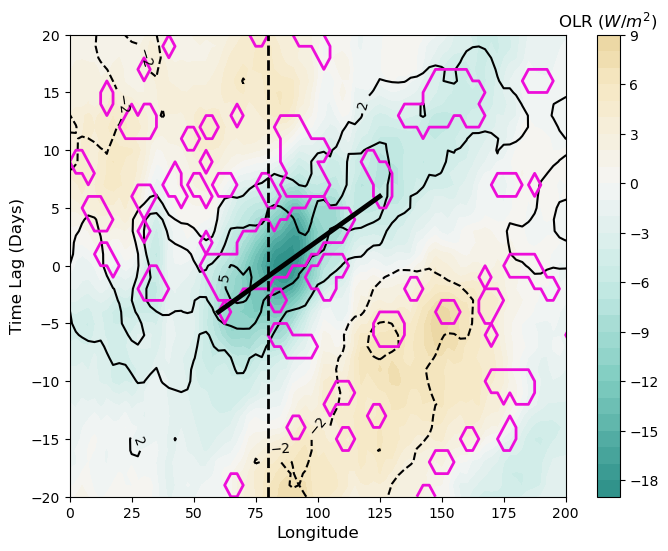

In [36]:
plt.figure(figsize=(8,6))

shum = plt.contourf(np.array(lon),np.arange(-maxlag,maxlag+1),lag_olr_mjo.T,30,cmap="BrBG_r",vmin=-30,vmax=30)
pos_con = plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),1E5*lag_shum_mjo.T,np.arange(2,12,1.5),colors="black") #positive prate anomalies
neg_con = plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),1E5*lag_shum_mjo.T,np.arange(-10,0,2),colors="black") #negative prate anomalies

plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),shum_significance.T,[1],colors="xkcd:fuchsia",linewidths=2) #significant geo hgt

plt.vlines(base_lon,-20,20,color="black",linestyle="--",linewidth=2) #base longitude

plt.plot((60,125),(-4,6),color='k',linewidth=3.5) #reference bar

plt.clabel(pos_con,poscon_label[::2])
plt.clabel(neg_con,negcon_label[::2])

cbr = plt.colorbar(shum)
cbr.ax.set_title('OLR ($W/m^2$)')
plt.xlim(0,200)
plt.xlabel("Longitude",fontsize=12)
plt.ylabel("Time Lag (Days)",fontsize=12)
# plt.title("OLR (shaded) and geopotential height (contours) at RMM phase "+str(base_phase),fontsize=14)
# plt.savefig("ATM561 Project/phase3_shum_80_nokelvin.png",dpi=300,bbox_inches="tight")

plt.show()

### Check if actual temperature is in 5% of null distribution

In [26]:
#get range of lower and upper 5% percentile
alpha = 0.025
sorted_temp = np.sort(rand_temp,axis=0)
lower_percent = sorted_temp[int(len(sorted_temp)*alpha)-1,:,:] #lower range
upper_percent = sorted_temp[-int(len(sorted_temp)*alpha),:,:] #upper range

In [27]:
temp_significance = np.zeros_like(lag_temp)

for i in range(lower_percent.shape[0]):
    for j in range(lower_percent.shape[1]):
        if lag_temp[i,j] <= lower_percent[i,j] or lag_temp[i,j] >= upper_percent[i,j]:
            temp_significance[i,j] = 1

In [28]:
poscon_label = np.arange(0.08,0.48,0.08)
negcon_label = np.arange(-0.4,0,0.08)

/tmp/ipykernel_26457/2925771565.py:7: UserWarning: No contour levels were found within the data range.
  plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),temp_significance.T,[1],colors="xkcd:fuchsia",linewidths=2) #significant geo hgt


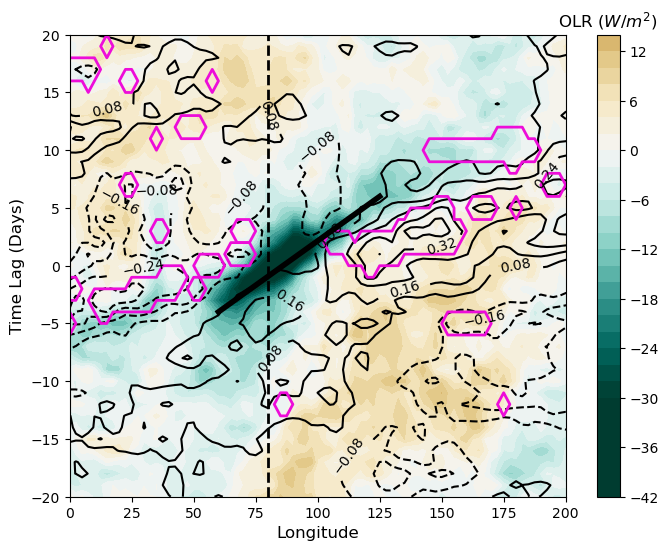

In [29]:
plt.figure(figsize=(8,6))

shum = plt.contourf(np.array(lon),np.arange(-maxlag,maxlag+1),lag_olr.T,30,cmap="BrBG_r",vmin=-30,vmax=30)
pos_con = plt.contour(np.array(temp_nc['lon']),np.arange(-maxlag,maxlag+1),lag_temp.T,np.arange(0.08,0.48,0.08),colors="black") #positive prate anomalies
neg_con = plt.contour(np.array(temp_nc['lon']),np.arange(-maxlag,maxlag+1),lag_temp.T,np.arange(-0.4,0,0.08),colors="black") #negative prate anomalies

plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),temp_significance.T,[1],colors="xkcd:fuchsia",linewidths=2) #significant geo hgt

plt.vlines(base_lon,-20,20,color="black",linestyle="--",linewidth=2) #base longitude

plt.plot((60,125),(-4,6),color='k',linewidth=4) #reference bar

plt.clabel(pos_con,poscon_label)
plt.clabel(neg_con,negcon_label)

cbr = plt.colorbar(shum)
cbr.ax.set_title('OLR ($W/m^2$)')
plt.xlim(0,200)
plt.xlabel("Longitude",fontsize=12)
plt.ylabel("Time Lag (Days)",fontsize=12)
# plt.title("OLR (shaded) and Temperature (contours) at RMM phase "+str(base_phase),fontsize=14)

# plt.savefig("ATM561 Project/phase3_temp_80.png",dpi=300,bbox_inches="tight")
plt.show()

In [30]:
#wake of vorticity and precip after kelvin wave
#cyclonic vorticity north and south but lags behind OLR center at equator
#make base index narrower in latitude (-7.5 to 7.5)
#stratoform rain: dry atmos but rainy
#vertical of temmp and humidity
#look at 850mb geopotential height
#pattern significance

## Plot composite of temperature and OLR without Kelvin wave

/tmp/ipykernel_26457/1843076723.py:7: UserWarning: No contour levels were found within the data range.
  plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),temp_significance.T,[1],colors="xkcd:fuchsia",linewidths=2) #significant geo hgt


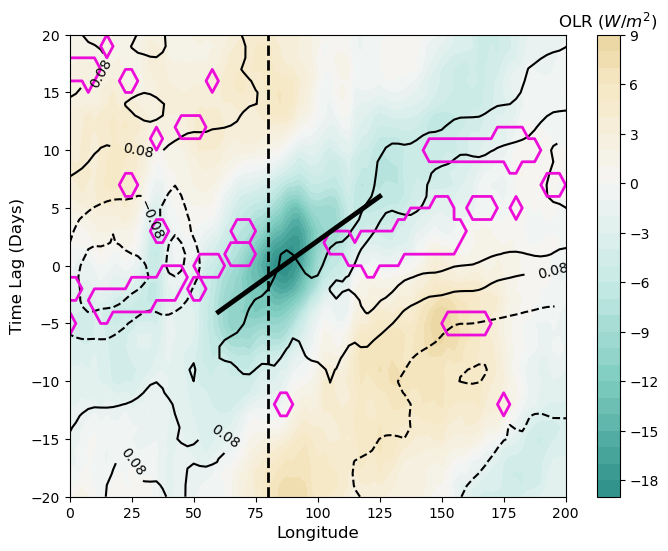

In [32]:
plt.figure(figsize=(8,6))

shum = plt.contourf(np.array(lon),np.arange(-maxlag,maxlag+1),lag_olr_mjo.T,30,cmap="BrBG_r",vmin=-30,vmax=30)
pos_con = plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),lag_temp_mjo.T,np.arange(0.08,0.48,0.08),colors="black") #positive prate anomalies
neg_con = plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),lag_temp_mjo.T,np.arange(-0.4,0,0.08),colors="black") #negative prate anomalies

plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),temp_significance.T,[1],colors="xkcd:fuchsia",linewidths=2) #significant geo hgt

plt.vlines(base_lon,-20,20,color="black",linestyle="--",linewidth=2) #base longitude

plt.plot((60,125),(-4,6),color='k',linewidth=3.5) #reference bar

plt.clabel(pos_con,poscon_label[::2])
plt.clabel(neg_con,negcon_label[::2])

cbr = plt.colorbar(shum)
cbr.ax.set_title('OLR ($W/m^2$)')
plt.xlim(0,200)
plt.xlabel("Longitude",fontsize=12)
plt.ylabel("Time Lag (Days)",fontsize=12)
# plt.title("OLR (shaded) and geopotential height (contours) at RMM phase "+str(base_phase),fontsize=14)
# plt.savefig("ATM561 Project/phase3_temp_80_nokelvin.png",dpi=300,bbox_inches="tight")

plt.show()